In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics, preprocessing
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle

In [33]:
train_df = pd.read_csv('combined_small.csv', sep='\t')
test_df = pd.read_csv('combined_test.csv', sep='\t')

In [34]:
#[["peak_1", "h_1", "k_1", "l_1", "peak_2", "h_2", "k_2", "l_2", "peak_3", "h_3", "k_3", "l_3", "peak_4", "h_4", "k_4", "l_4", "peak_5", "h_5", "k_5", "l_5", "peak_6", "h_6", "k_6", "l_6", "peak_7", "h_7", "k_7", "l_7", "peak_8", "h_8", "k_8", "l_8", "peak_9", "h_9", "k_9", "l_9", "peak_10", "h_10", "k_10", "l_10" ]]

In [35]:
X_test = test_df[["peak_1", "peak_2", "peak_3", "peak_4","peak_5", "peak_6", "peak_7", "peak_8", "peak_9", "peak_10"]]
y_test = test_df['codes']

In [36]:
np.shape(train_df[["peak_1", "peak_2", "peak_3", "peak_4","peak_5", "peak_6", "peak_7", "peak_8", "peak_9", "peak_10"]])

(210000, 10)

In [10]:
np.shape(X_test)

(1080, 10)

In [11]:
X_test_re = X_test.values.reshape(1080,10,1)

In [12]:
measured_test_labels = to_categorical(y_test)

In [97]:
def get_model(i, f1, f2, k_size_1, k_size_2, strd, len1, len2, drop):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=f1, kernel_size=k_size_1, strides=strd, padding="same", activation="relu", input_shape=(i,1)))
    model.add(layers.MaxPooling1D(1))
    model.add(layers.Conv1D(filters=f2, kernel_size=k_size_2, strides=strd, padding="same", activation="relu"))
    model.add(layers.MaxPooling1D(1))
    model.add(layers.Conv1D(filters=f2, kernel_size=k_size_2, strides=strd, padding="same", activation="relu"))
    model.add(layers.MaxPooling1D(1))
    model.add(layers.Dense(len1, kernel_initializer='he_uniform', activation='relu', input_dim=i))
    model.add(layers.Dropout(drop))
    model.add(layers.Flatten())
    model.add(layers.Dense(len2, kernel_initializer='he_uniform', activation='relu'))
    model.add(layers.Dropout(drop))
    model.add(layers.Dense(21, activation='sigmoid'))
    return model

In [103]:
def get_history(model, test_size, val_size, epochs, batch_size):
    peaks= train_df[["peak_1", "peak_2", "peak_3", "peak_4","peak_5", "peak_6", "peak_7", "peak_8", "peak_9", "peak_10"]]
    code = train_df["codes"]

    training_data = pd.concat([peaks, code], axis=1)

    training_data = shuffle(training_data)

    X = training_data.drop(["codes"], axis=1)
    y = training_data["codes"]

    X = X.round(6)
    
    X_re = X.values.reshape(210000,10,1)

    train_features, test_features, train_labels, test_labels = train_test_split(X, 
                                                        y, 
                                                        test_size=test_size, 
                                                        random_state=42)

    one_hot_train_labels = to_categorical(train_labels)
    one_hot_test_labels = to_categorical(test_labels)

    X_val = train_features[:val_size]
    partial_X_train = train_features[val_size:]
    y_val = one_hot_train_labels[:val_size]
    partial_y_train = one_hot_train_labels[val_size:]

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    
    return history, test_features, one_hot_test_labels

In [121]:
model = models.Sequential()
model.add(layers.Dense(1000, kernel_initializer='he_uniform', activation='relu', input_dim=10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(500, kernel_initializer='he_uniform', activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(500, kernel_initializer='he_uniform', activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(21, activation='sigmoid'))

In [122]:
history, features, labels = get_history(model, 0.25, 10000, 10, 100)

Train on 147500 samples, validate on 10000 samples
Epoch 1/10
147500/147500 [==============================] - 22s 149us/sample - loss: 0.2227 - accuracy: 0.9493 - val_loss: 0.1228 - val_accuracy: 0.9524
Epoch 2/10
147500/147500 [==============================] - 21s 146us/sample - loss: 0.1356 - accuracy: 0.9546 - val_loss: 0.1006 - val_accuracy: 0.9609
Epoch 3/10
147500/147500 [==============================] - 22s 146us/sample - loss: 0.1153 - accuracy: 0.9601 - val_loss: 0.0900 - val_accuracy: 0.9680
Epoch 4/10
147500/147500 [==============================] - 23s 155us/sample - loss: 0.0593 - accuracy: 0.9772 - val_loss: 0.0202 - val_accuracy: 0.9899
Epoch 5/10
147500/147500 [==============================] - 21s 144us/sample - loss: 0.0177 - accuracy: 0.9927 - val_loss: 0.0131 - val_accuracy: 0.9929
Epoch 6/10
147500/147500 [==============================] - 21s 144us/sample - loss: 0.0137 - accuracy: 0.9944 - val_loss: 0.0077 - val_accuracy: 0.9962
Epoch 7/10
147500/147500 [=====

In [131]:
model.evaluate(features, labels)

52500/52500 [==============================] - 4s 71us/sample - loss: 0.0071 - accuracy: 0.9964s - loss: 0.0071 - 


[0.007076689472927579, 0.9964231]

In [123]:
model.evaluate(X_test, measured_test_labels)

1080/1080 [==============================] - 0s 78us/sample - loss: 0.2720 - accuracy: 0.9511


[0.27201404251434186, 0.95105815]

In [130]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 1000)              11000     
_________________________________________________________________
dropout_41 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_42 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_43 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 21)              

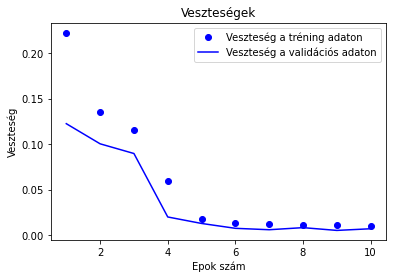

In [124]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Veszteség a tréning adaton')
plt.plot(epochs, val_loss, 'b', label='Veszteség a validációs adaton')
plt.title('Veszteségek')
plt.xlabel('Epok szám')
plt.ylabel('Veszteség')
plt.legend()
plt.savefig("loss_cubic_symmetry")
plt.show()

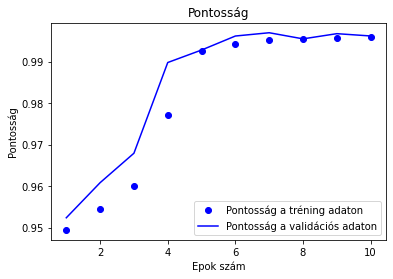

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'bo', label='Pontosság a tréning adaton')
plt.plot(epochs, val_acc, 'b', label='Pontosság a validációs adaton')
plt.title('Pontosság')
plt.xlabel('Epok szám')
plt.ylabel('Pontosság')
plt.legend()
plt.savefig("acc_cubic_symmetry")
plt.show()

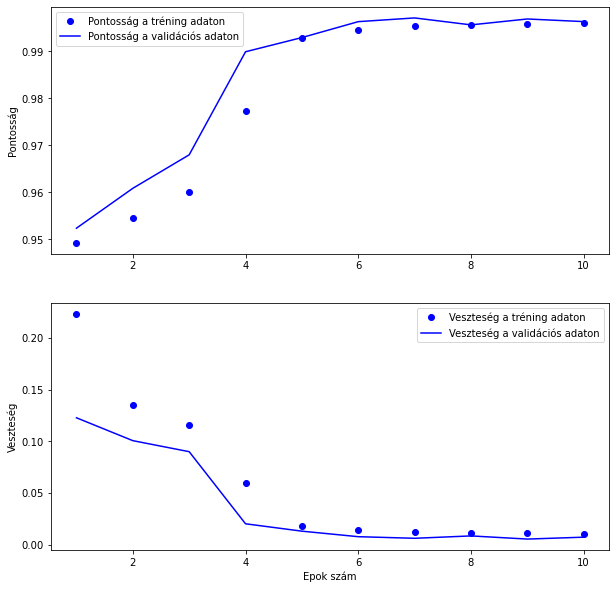

In [127]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
ax1.plot(epochs, acc, 'bo', label='Pontosság a tréning adaton')
ax1.plot(epochs, val_acc, 'b', label='Pontosság a validációs adaton')
ax1.set_ylabel('Pontosság')
ax1.legend()
ax2.plot(epochs, loss, 'bo', label='Veszteség a tréning adaton')
ax2.plot(epochs, val_loss, 'b', label='Veszteség a validációs adaton')
ax2.set_xlabel('Epok szám')
ax2.set_ylabel('Veszteség')
ax2.legend()
plt.savefig('sym_multiple')